<a href="https://colab.research.google.com/github/MPGarg/Assignment-8/blob/main/EVA8_Assigment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
#!pip install -U albumentations
!pip install torch_lr_finder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch_lr_finder import LRFinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import files from GIT Hub

In [ ]:
!git clone https://github.com/MPGarg/main_repo.git

Cloning into 'main_repo'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 101 (delta 20), reused 0 (delta 0), pack-reused 52
Receiving objects: 100% (101/101), 36.94 KiB | 18.47 MiB/s, done.
Resolving deltas: 100% (40/40), done.


# Custom ResNet class is imported

In [ ]:
from main_repo.models import custom_resnet
from main_repo.models.custom_resnet import Custom_ResNet

# Import Other fuctions

In [ ]:
from main_repo import main, utils
from main_repo.utils import *    
from main_repo.main import train, test, fit_model

# Assign device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
view_model = Custom_ResNet().to(device)
summary(view_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         Dropout2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
         Dropout2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
        Dropout2d-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Show sample images and Load dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


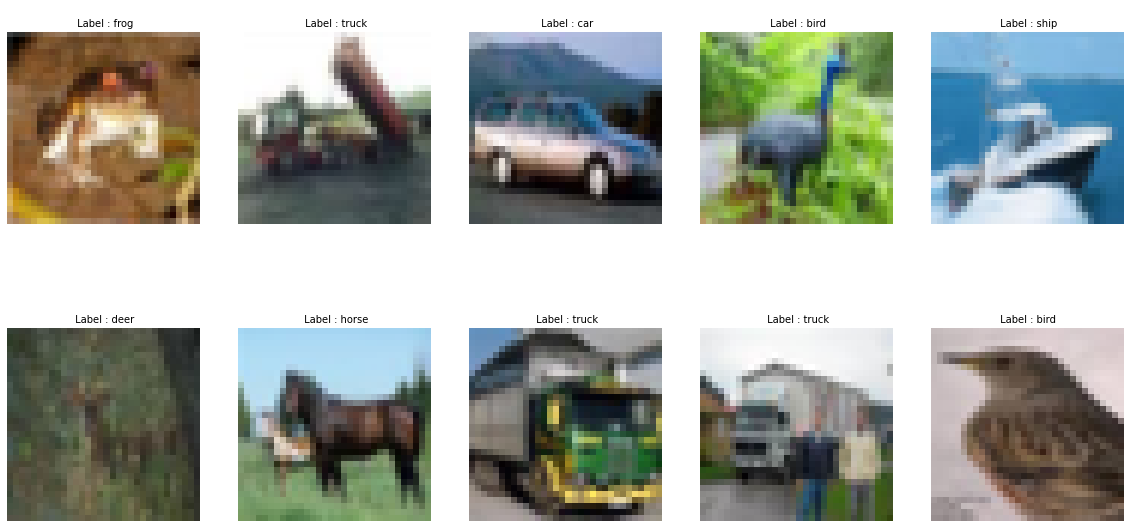

In [ ]:
trainset_mod, trainloader_mod, testset_mod, testloader_mod,mean, std,trainset_lr,trainloader_lr = process_dataset(visualize = 'X')     

# Find Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.61E-02


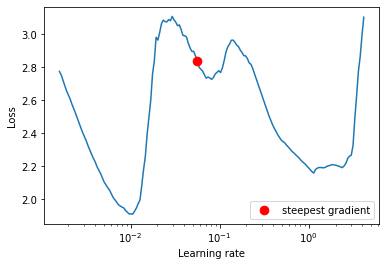

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa0d67cd520>,
 0.056071699382054585)

In [ ]:
import copy
model = Custom_ResNet(0.05).to(device)
model_exp = copy.deepcopy(model)
optimizer = torch.optim.SGD(model_exp.parameters(), lr=0.001, momentum=0.9,weight_decay=0.02)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader_lr, end_lr=10, num_iter=200)
lr_finder.plot() 

In [ ]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.01059560179277616


# Train & Test Model

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=ler_rate/10, momentum=0.9,weight_decay=0.02)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(trainloader_mod), 
                                                epochs=24,
                                                pct_start=0.15,
                                                div_factor=10,
                                                three_phase=False, 
                                                #final_div_factor=1000,
                                                anneal_strategy='linear'
                                                ) 

model_tr, wrong_prediction_list, right_prediction_list, train_losses, train_acc, test_losses, test_acc = fit_model(
                                                    model=model, 
                                                    device=device,
                                                    trainloader=trainloader_mod, 
                                                    testloader=testloader_mod,
                                                    criterion = nn.CrossEntropyLoss(),
                                                    EPOCHS=24,
                                                    optimizer=optimizer,
                                                    scheduler=scheduler
                                                    
                                                )

EPOCH: 1 (LR: 0.001059560179277616)


100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


Average Training Loss=0.0034502442479133607, Accuracy=37.374


Test set: Average loss: 0.0025, Accuracy: 5469/10000 (54.69%)

EPOCH: 2 (LR: 0.003715990190996937)


100%|██████████| 98/98 [00:25<00:00,  3.85it/s]


Average Training Loss=0.002390828092098236, Accuracy=56.474


Test set: Average loss: 0.0019, Accuracy: 6640/10000 (66.40%)

EPOCH: 3 (LR: 0.006372420202716259)


100%|██████████| 98/98 [00:24<00:00,  3.93it/s]


Average Training Loss=0.0018612290751934052, Accuracy=66.608


Test set: Average loss: 0.0015, Accuracy: 7292/10000 (72.92%)

EPOCH: 4 (LR: 0.00902885021443558)


100%|██████████| 98/98 [00:25<00:00,  3.92it/s]


Average Training Loss=0.001510519644021988, Accuracy=73.134


Test set: Average loss: 0.0014, Accuracy: 7651/10000 (76.51%)

EPOCH: 5 (LR: 0.010382547104582042)


100%|██████████| 98/98 [00:25<00:00,  3.89it/s]


Average Training Loss=0.0012679439413547516, Accuracy=77.668


Test set: Average loss: 0.0012, Accuracy: 7926/10000 (79.26%)

EPOCH: 6 (LR: 0.00986316005376056)


100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


Average Training Loss=0.0011167262518405915, Accuracy=80.264


Test set: Average loss: 0.0011, Accuracy: 8180/10000 (81.80%)

EPOCH: 7 (LR: 0.00934377300293908)


100%|██████████| 98/98 [00:25<00:00,  3.92it/s]


Average Training Loss=0.00099694271504879, Accuracy=82.682


Test set: Average loss: 0.0010, Accuracy: 8343/10000 (83.43%)

EPOCH: 8 (LR: 0.008824385952117597)


100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


Average Training Loss=0.0009172457861900329, Accuracy=84.336


Test set: Average loss: 0.0010, Accuracy: 8383/10000 (83.83%)

EPOCH: 9 (LR: 0.008304998901296115)


100%|██████████| 98/98 [00:24<00:00,  3.93it/s]


Average Training Loss=0.0008470910394191742, Accuracy=85.492


Test set: Average loss: 0.0010, Accuracy: 8335/10000 (83.35%)

EPOCH: 10 (LR: 0.007785611850474632)


100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


Average Training Loss=0.0007985779517889023, Accuracy=86.572


Test set: Average loss: 0.0009, Accuracy: 8566/10000 (85.66%)

EPOCH: 11 (LR: 0.00726622479965315)


100%|██████████| 98/98 [00:25<00:00,  3.89it/s]


Average Training Loss=0.0007524771696329117, Accuracy=87.34


Test set: Average loss: 0.0008, Accuracy: 8653/10000 (86.53%)

EPOCH: 12 (LR: 0.006746837748831669)


100%|██████████| 98/98 [00:25<00:00,  3.88it/s]


Average Training Loss=0.0007071340048313141, Accuracy=88.438


Test set: Average loss: 0.0008, Accuracy: 8698/10000 (86.98%)

EPOCH: 13 (LR: 0.006227450698010187)


100%|██████████| 98/98 [00:24<00:00,  3.93it/s]


Average Training Loss=0.0006853963512182236, Accuracy=88.914


Test set: Average loss: 0.0008, Accuracy: 8649/10000 (86.49%)

EPOCH: 14 (LR: 0.005708063647188705)


100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


Average Training Loss=0.0006435027509927749, Accuracy=89.63


Test set: Average loss: 0.0008, Accuracy: 8591/10000 (85.91%)

EPOCH: 15 (LR: 0.005188676596367223)


100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


Average Training Loss=0.0006226305139064789, Accuracy=90.138


Test set: Average loss: 0.0008, Accuracy: 8702/10000 (87.02%)

EPOCH: 16 (LR: 0.00466928954554574)


100%|██████████| 98/98 [00:25<00:00,  3.89it/s]


Average Training Loss=0.0005862729671597481, Accuracy=90.736


Test set: Average loss: 0.0007, Accuracy: 8939/10000 (89.39%)

EPOCH: 17 (LR: 0.0041499024947242585)


100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


Average Training Loss=0.0005564318570494652, Accuracy=91.362


Test set: Average loss: 0.0007, Accuracy: 8868/10000 (88.68%)

EPOCH: 18 (LR: 0.0036305154439027765)


100%|██████████| 98/98 [00:25<00:00,  3.89it/s]


Average Training Loss=0.0005327880480885506, Accuracy=91.794


Test set: Average loss: 0.0006, Accuracy: 8970/10000 (89.70%)

EPOCH: 19 (LR: 0.0031111283930812953)


100%|██████████| 98/98 [00:24<00:00,  3.93it/s]


Average Training Loss=0.0004897090500593185, Accuracy=92.744


Test set: Average loss: 0.0006, Accuracy: 9020/10000 (90.20%)

EPOCH: 20 (LR: 0.0025917413422598123)


100%|██████████| 98/98 [00:24<00:00,  3.95it/s]


Average Training Loss=0.00046001296043395994, Accuracy=93.312


Test set: Average loss: 0.0006, Accuracy: 9048/10000 (90.48%)

EPOCH: 21 (LR: 0.002072354291438332)


100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


Average Training Loss=0.0004176852083206177, Accuracy=94.074


Test set: Average loss: 0.0005, Accuracy: 9119/10000 (91.19%)

EPOCH: 22 (LR: 0.0015529672406168482)


100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


Average Training Loss=0.000376412578523159, Accuracy=94.766


Test set: Average loss: 0.0005, Accuracy: 9125/10000 (91.25%)

EPOCH: 23 (LR: 0.0010335801897953661)


100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


Average Training Loss=0.0003192255079746246, Accuracy=95.912


Test set: Average loss: 0.0005, Accuracy: 9244/10000 (92.44%)

EPOCH: 24 (LR: 0.0005141931389738858)


100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


Average Training Loss=0.00028512288123369215, Accuracy=96.6


Test set: Average loss: 0.0004, Accuracy: 9302/10000 (93.02%)

Total Number of incorrectly predicted images by model is 698


# Display Validation Accuracy & Loss

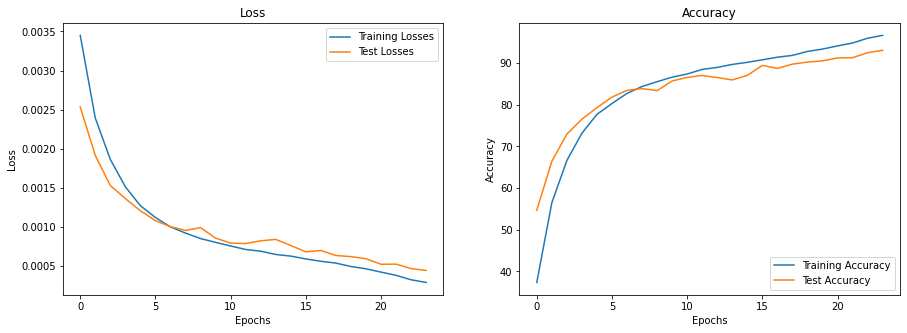

In [ ]:
plot_acc_loss(train_acc,train_losses,test_acc,test_losses)

# Display wrong prediction

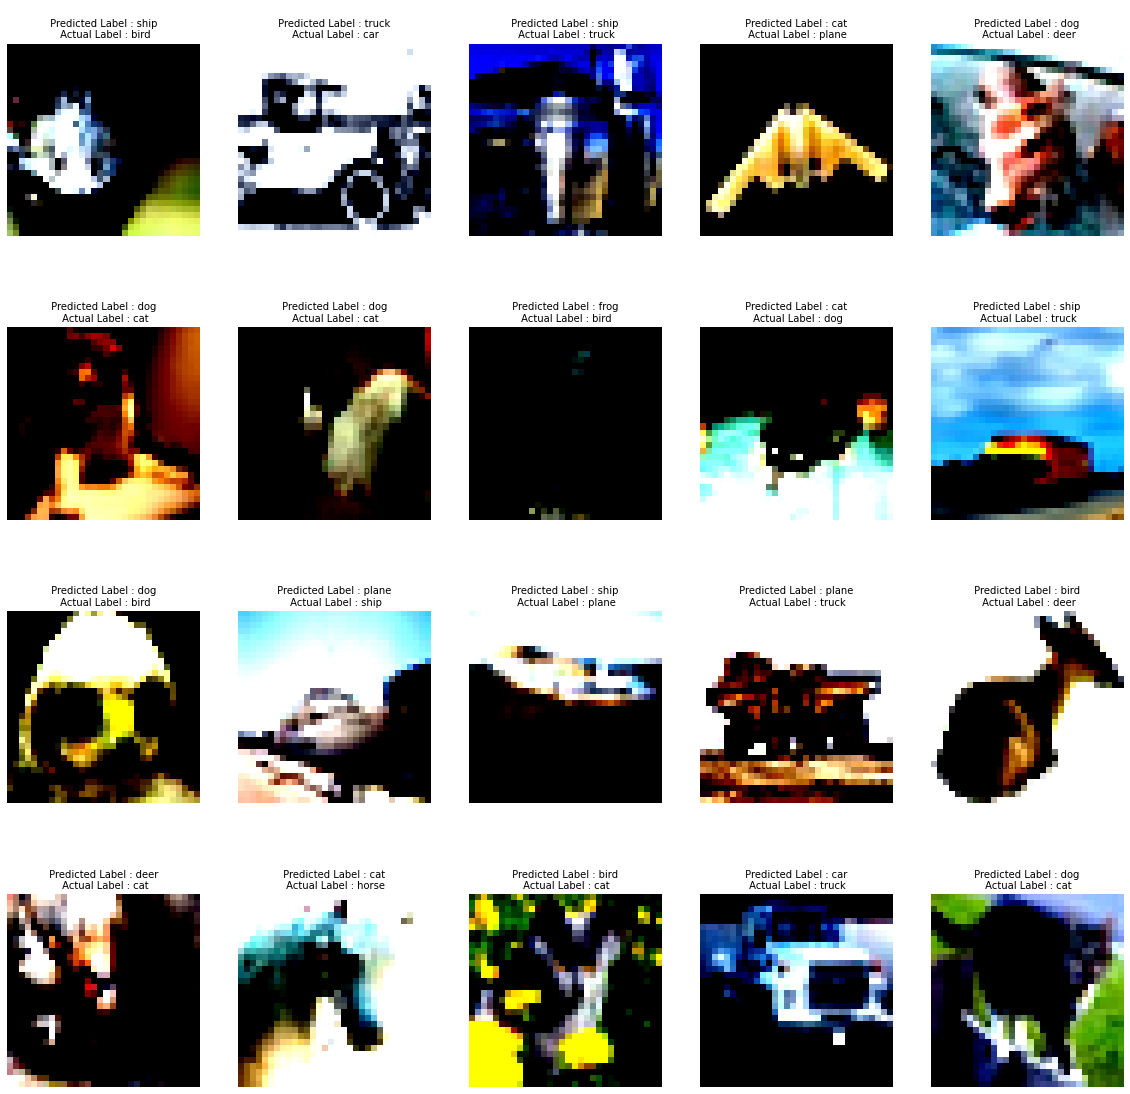

In [ ]:
display_incorrect_pred(wrong_prediction_list)

# GradCam 

In [ ]:
target_layers = ["layer1", "layer2","layer3"]
torch.autograd.set_detect_anomaly(True)

In [ ]:
from main_repo.utils import generate_gradcam, plot_gradcam
gradcam_output, probs, predicted_classes = generate_gradcam(wrong_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


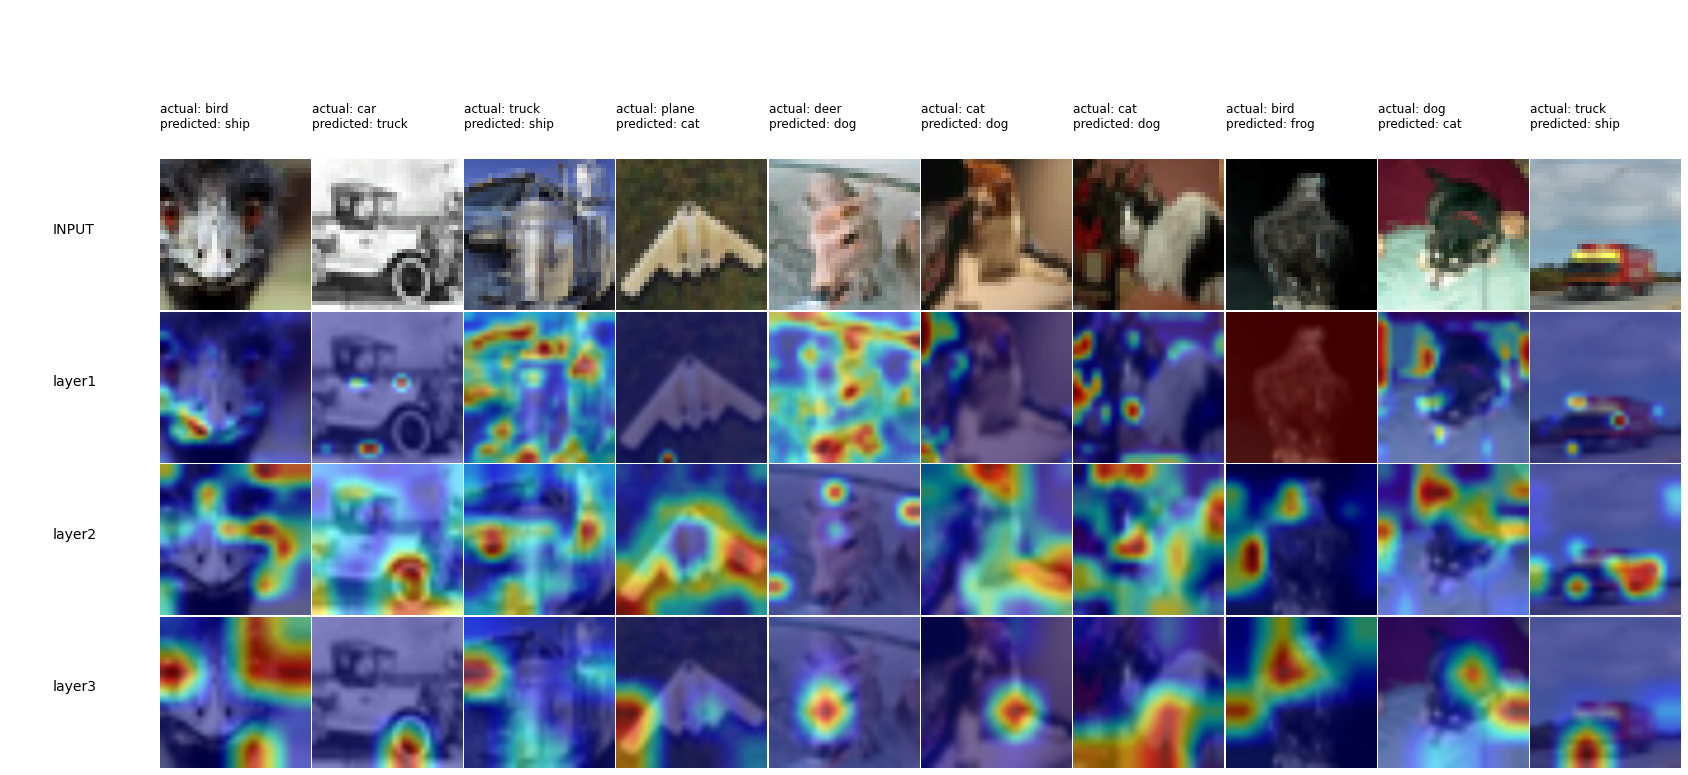

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, wrong_prediction_list[:10],mean,std)

In [ ]:
gradcam_output, probs, predicted_classes = generate_gradcam(right_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


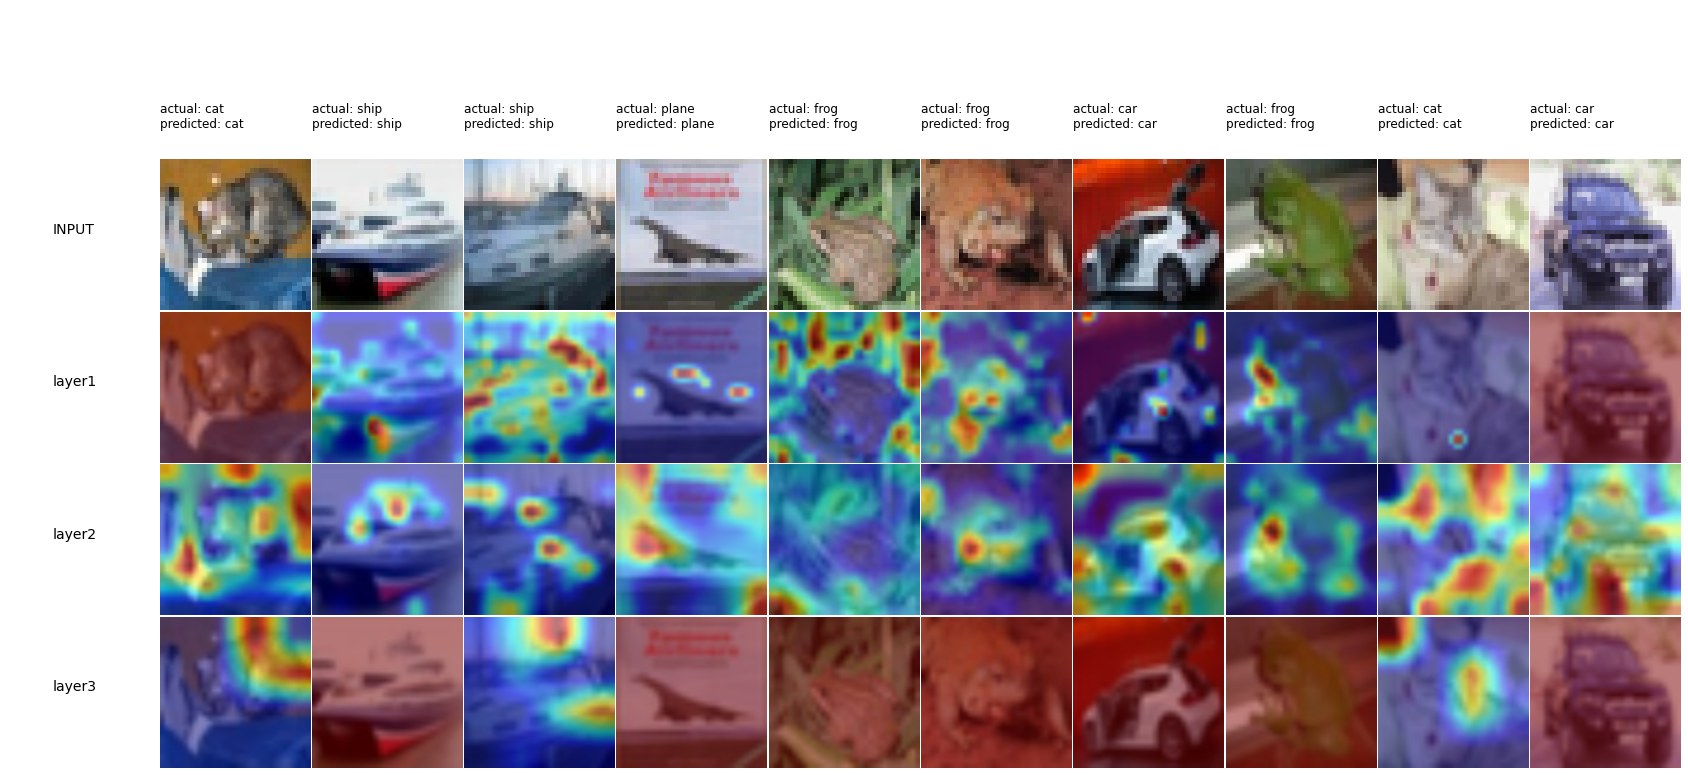

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, right_prediction_list[:10],mean,std)